# Regression

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
# Example usage:
import jax
import jax.numpy as jnp
from helper import get_sinusoid_example

n_data = 150
sigma_noise = 0.3
batch_size = 150
rng_key = jax.random.key(711)

X_train, y_train, train_loader, X_test = get_sinusoid_example(n_data, sigma_noise, batch_size, rng_key)
train_loader = list(zip(X_train, y_train, strict=False))

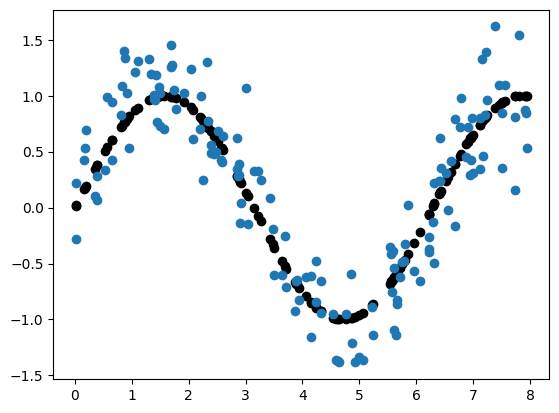

In [3]:
import matplotlib.pyplot as plt 

plt.scatter(X_train, jnp.sin(X_train), color='black', label='sin(x)')
plt.scatter(X_train, y_train)

In [4]:
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from jax import random
from functools import partial

# Create the model using Flax's linen module
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x
    
# Initialize the model and defkne the loss funciton 
def create_model(rng):
    model = MLP()
    params = model.init(rng, jnp.ones([1, 1]))
    return model, params

# Mean squared error loss function
def mse_loss(params, model, X, y):
    predictions = model.apply(params, X)
    loss = jnp.mean((predictions - y) ** 2)
    return loss

# Update function using Optax
def update(params, opt_state, X, y, model, optimizer):
    loss, grads = jax.value_and_grad(mse_loss)(params, model, X, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

In [5]:

# Training loop
def train_model(train_loader, n_epochs, rng_key):
    rng, init_rng = random.split(rng_key)
    model, params = create_model(init_rng)
    
    optimizer = optax.adam(learning_rate=1e-2)
    opt_state = optimizer.init(params)
    
    for _ in range(n_epochs):
        for X, y in train_loader:
            params, opt_state, _ = update(params, opt_state, X, y, model, optimizer)
            # You can log the loss here if you want
    return model, params


# Example usage:
# Assuming `train_loader` is a generator that yields (X, y) batches
n_epochs = 10
rng_key = random.key(711)
model, final_params = train_model(train_loader, n_epochs, rng_key)

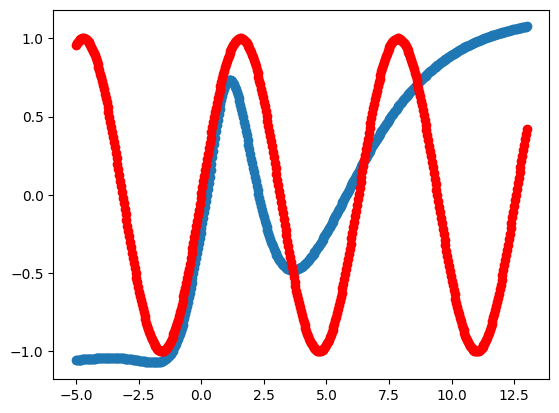

In [6]:
pred = model.apply(final_params, X_test)
plt.scatter(X_test, pred)
plt.scatter(X_test, jnp.sin(X_test), color='red')

In [7]:
loss_fn = lambda y_pred, y_true: jnp.mean((y_pred - y_true) ** 2) # noqa: E731
model_fn = lambda p, x: model.apply(p, x)  # noqa: E731, PLW0108
full_fn = lambda p, data: loss_fn(model_fn(p, data[0]), data[1])  # noqa: E731


In [8]:
from laplax.curv.full import estimate_hessian, flatten_hessian

hessian = estimate_hessian(full_fn, final_params, (X_train, y_train))
flat_hessian = flatten_hessian(hessian, final_params)
flat_hessian = (flat_hessian + flat_hessian.T) / 2

In [9]:
from laplax.curv.full import cov_scale_full_hessian

cov_scale = cov_scale_full_hessian(flat_hessian, 2, 100*jnp.eye(flat_hessian.shape[0]))


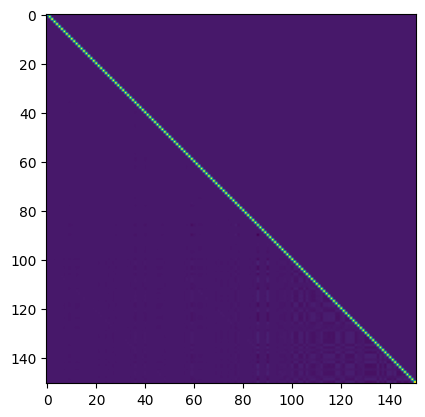

In [10]:
plt.imshow(cov_scale)

In [11]:
flat_params, def_params = jax.tree_util.tree_flatten(final_params)
mean = jnp.concatenate([p.flatten() for p in flat_params])
params_shape = jnp.cumsum(jnp.asarray([jnp.prod(jnp.asarray(p.shape)) for p in flat_params]))

In [12]:
from jaxtyping import PyTree


def create_param_builder(final_params: PyTree) -> callable:
    """Create PyTree Reconstruction."""
    flat_params, def_params = jax.tree_util.tree_flatten(final_params)
    params_shape = [p.shape for p in flat_params]
    params_index = jnp.cumsum(jnp.asarray([jnp.prod(jnp.asarray(p.shape)) for p in flat_params]))[:-1]
    return lambda x: jax.tree_util.tree_unflatten(def_params, [p.reshape(pshape) for p, pshape in zip(jnp.split(x, params_index), params_shape)])


param_builder = create_param_builder(final_params)

In [13]:
from laplax.eval.push_forward import create_mc_predictions_for_data_point_fn

rng_key = jax.random.key(711)
samples = jax.random.multivariate_normal(
    rng_key, mean, cov_scale, shape=(1000,)
)

In [14]:
from laplax.eval.metrics import estimate_q
from laplax.eval.utils import evaluate_metrics_on_dataset

ptw_pred_fn = create_mc_predictions_for_data_point_fn(
    model_fn, mean, cov_scale, param_builder
)

metrics = evaluate_metrics_on_dataset(
    ptw_pred_fn, (X_test, jnp.sin(X_test)), metrics = [estimate_q]
)

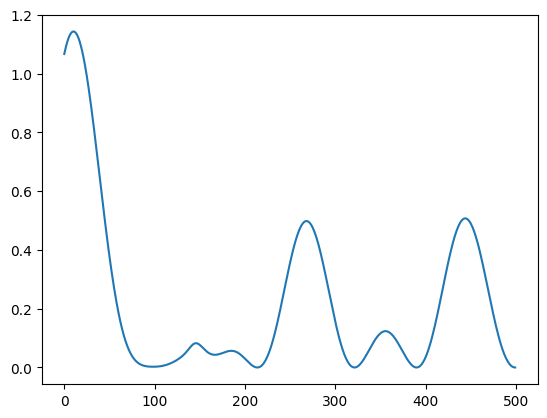

In [15]:
plt.plot(metrics['estimate_q'])